In [1]:
#To identify which sub-networks i.e. communities, are of interest, we'll calculate the correlation between the networks and the
#relevant clinical metadata variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pickle
import seaborn as sns

In [3]:
#Read in required data

In [4]:
#Load in the required data
datExpr = pd.read_csv('/data/recode/mic_datExpr_pseudobulk.csv', index_col = 0)
metadata = pd.read_csv('/da/recode/mic_metadata_pseudobulk.csv', index_col = 0)

In [5]:
datExpr

,SAR1A,IER3,ATXN7,MRPL32,RASGEF1C,HMG20B,RAB11FIP2,GEM,TREM1,MEPE,...,MAN1A2,EDA,TMLHE,ECH1,APEX2,FCGR3A,SMUG1,HEATR5A,ARL2-SNX15,NRBP2
donor_id,,,,,,,,,,,,,,,,,,,,,
1,3.465736,19.238222,4.158883,0.693147,29.347748,1.386294,4.158883,0.693147,0.000000,0.000000,...,7.336937,5.950643,3.465736,0.000000,1.386294,4.158883,0.693147,2.079442,1.386294,4.969813
2,1.386294,5.662960,11.783503,0.693147,65.928200,6.931472,4.158883,0.000000,0.000000,0.000000,...,5.950643,11.090355,4.852030,1.386294,0.000000,5.545178,0.693147,5.257495,0.693147,1.791759
3,0.000000,1.386294,2.079442,0.000000,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,...,2.079442,1.386294,0.000000,0.000000,0.000000,1.386294,0.000000,1.386294,0.000000,0.693147
4,0.000000,3.871201,0.693147,0.000000,4.852030,2.079442,1.386294,0.000000,0.000000,0.000000,...,4.158883,2.772589,0.693147,1.386294,0.000000,4.852030,1.098612,0.693147,0.000000,1.386294
5,0.693147,3.465736,5.257495,1.386294,18.139610,2.772589,2.772589,0.000000,0.000000,0.000000,...,7.336937,6.931472,2.772589,2.302585,0.000000,13.693045,1.386294,1.386294,3.465736,0.693147
6,9.639523,13.117681,11.495820,3.465736,4.158883,10.227308,4.969813,0.693147,0.000000,0.000000,...,23.920353,13.575262,6.238325,3.465736,3.583519,40.385986,3.178054,6.461468,8.317766,3.178054
7,9.704061,35.180607,62.279015,9.234056,288.971860,13.575262,27.843670,1.791759,0.000000,1.098612,...,76.418350,73.423744,57.480230,2.772589,3.871201,64.018660,5.257495,25.764229,6.238325,7.742402
8,32.002552,33.506630,44.884666,9.010914,153.331540,15.249238,13.169796,0.693147,0.000000,0.693147,...,53.032536,58.747612,25.071081,4.852030,5.545178,19.525904,8.723231,24.495718,39.627174,7.624619
9,68.281780,40.032640,44.021620,10.397207,53.032536,9.704061,22.991640,6.356108,1.791759,3.465736,...,52.796970,54.706512,21.487562,9.010914,2.079442,63.429740,2.772589,27.725887,432.745900,4.852030


In [6]:
metadata

,donor_id.1,BraakStage,nUMI,nGene,seurat.subclusters,development_stage,AD,Normal
donor_id,,,,,,,,
1,1,0,302.0,268,1,50,0,1
2,2,0,676.0,553,1,60,0,1
3,3,0,219.0,193,0,71,0,1
4,4,2,348.0,295,0,72,1,0
5,5,2,447.0,328,1,77,1,0
6,6,2,376.0,328,2,87,1,0
7,7,2,1399.0,965,1,80,1,0
8,8,6,619.0,500,0,72,1,0
9,9,6,531.0,437,0,82,1,0


In [8]:
gene_names = datExpr.columns
gene_names

Index(['SAR1A', 'IER3', 'ATXN7', 'MRPL32', 'RASGEF1C', 'HMG20B', 'RAB11FIP2',
       'GEM', 'TREM1', 'MEPE',
       ...
       'MAN1A2', 'EDA', 'TMLHE', 'ECH1', 'APEX2', 'FCGR3A', 'SMUG1', 'HEATR5A',
       'ARL2-SNX15', 'NRBP2'],
      dtype='object', length=999)

In [9]:
with open('/shared/as8020/recode/separated_communities.pkl', 'rb') as file:
        separated_communities = pickle.load(file)

In [10]:
print(separated_communities)

[['ARHGAP11A', 'PBX3', 'ERO1A', 'RGS10', 'DHX29', 'TNIK', 'PRELID2', 'ZMAT3', 'MGLL', 'KIF23', 'RFX7', 'HMG20B', 'STAU2', 'S100A4', 'SELENOP', 'DPY19L3', 'NKAIN2', 'RPL18A', 'MYBPH', 'MAP2K6', 'CTTNBP2', 'ZNF883', 'VPS54', 'LMO7', 'TPX2', 'NELFB', 'MSI2', 'TENM2', 'PTCHD4', 'FOXN2', 'CDK8', 'KNOP1', 'PRF1', 'NOL4L', 'HRH1', 'SLC22A23', 'CNOT6L', 'IFT81', 'FAM117B', 'THEMIS', 'GALM', 'RALGPS2', 'NIF3L1', 'CD247', 'GASK1B', 'S100A11', 'INPP4B', 'RAB42', 'CFAP157', 'PPM1G', 'TMOD2', 'ANKRD26', 'IQGAP2', 'RAD18', 'CYTL1', 'ISYNA1', 'DUSP22', 'EEA1', 'PEX12', 'FOXP2', 'VMO1', 'CADM2', 'RNF19B', 'C5orf34', 'HTR7', 'TSHR', 'SYNE1', 'BTBD17', 'THRB', 'CIP2A', 'CHAT', 'USP35', 'RASGEF1C', 'BNIP3L', 'TMEM236', 'NRP2', 'FTCD', 'CPVL', 'EXOC1', 'CCDC146', 'CADM1', 'KCNIP1', 'FAM177B', 'CST7', 'TNFRSF11B', 'SP140', 'AZGP1', 'ERO1B', 'EBF1', 'MAP2', 'PCDH15', 'TNFSF13B', 'RNF19A', 'BRCA2', 'MT-CO1', 'MT-CYB', 'UBE2C', 'DLC1', 'HLCS', 'MCTP2', 'ZFC3H1', 'MT-CO2', 'GJB1', 'SEMA4D', 'KLRF1', 'NUPR1', '

In [ ]:
#Module eigengene calculation
#Module eigengene calculation is a concept used in the analysis of gene expression data.

#Module/sub-network: A module refers to a group of genes that exhibit similar expression patterns across samples. Modules are often identified using clustering algorithms applied to gene expression data.
#Eigengene: An eigengene represents the overall expression profile of a module. It is calculated as the first principal component of the gene expression profiles within the module. Essentially, the eigengene captures the main axis of variation or the common expression pattern shared by the genes within the module.

#We will be using module eigengenes as representations for further downstream analysis.

In [11]:
# Initialise a DataFrame to store module eigengenes
module_eigengenes = pd.DataFrame(index=datExpr.index)

# Calculate the module eigengene for each community
for i, community in enumerate(separated_communities):
    community_genes = [gene for gene in community if gene in gene_names]
    if community_genes:
        community_expr = datExpr[community_genes]
        pca = PCA(n_components=1)
        eigengene = pca.fit_transform(community_expr)
        module_eigengenes[f'Module_{i+1}'] = eigengene[:, 0]

In [12]:
metadata

,donor_id.1,BraakStage,nUMI,nGene,seurat.subclusters,development_stage,AD,Normal
donor_id,,,,,,,,
1,1,0,302.0,268,1,50,0,1
2,2,0,676.0,553,1,60,0,1
3,3,0,219.0,193,0,71,0,1
4,4,2,348.0,295,0,72,1,0
5,5,2,447.0,328,1,77,1,0
6,6,2,376.0,328,2,87,1,0
7,7,2,1399.0,965,1,80,1,0
8,8,6,619.0,500,0,72,1,0
9,9,6,531.0,437,0,82,1,0


In [13]:
metadata2 = metadata.drop(columns=['donor_id.1','nUMI', 'nGene','seurat.subclusters'])

In [14]:
# Merge module eigengenes with metadata
merged_data = pd.concat([metadata2, module_eigengenes], axis=1)

In [15]:
merged_data

,BraakStage,development_stage,AD,Normal,Module_1,Module_2,Module_3,Module_4,Module_5,Module_6,Module_7,Module_8,Module_9,Module_10,Module_11
donor_id,,,,,,,,,,,,,,,
1,0,50,0,1,-610.707328,-371.025703,-14.891178,-0.781007,-6.740630,-30.867574,-0.179176,0.791230,-0.415888,-0.456435,-0.387120
2,0,60,0,1,-506.503345,-396.464531,-19.113032,0.192234,-9.225537,-24.916931,-0.179176,0.791230,0.970406,-0.456435,-0.387120
3,0,71,0,1,-779.918207,-445.492776,-22.577451,-0.781007,-12.978955,-33.234697,0.919436,-0.595064,0.277259,0.642177,-0.387120
4,2,72,1,0,-751.444429,-434.700876,-19.679678,2.279947,-11.998126,-33.640162,-0.179176,0.791230,-0.415888,-0.456435,-0.387120
5,2,77,1,0,-573.145757,-386.226367,-14.917519,-0.781007,-11.998126,-25.204613,-0.179176,-0.595064,-0.415888,0.929860,1.404639
6,2,87,1,0,-336.522011,-210.606298,-9.259815,0.075145,-8.532390,-11.511568,-0.179176,-0.595064,-0.415888,-0.456435,-0.387120
7,2,80,1,0,847.212832,67.004412,15.717738,-0.781007,16.474153,31.059223,0.513971,-0.595064,-0.415888,0.236712,-0.387120
8,6,72,1,0,812.334778,164.977930,35.662974,-0.781007,13.478421,16.096536,-0.179176,1.196695,-0.415888,-0.456435,0.999174
9,6,82,1,0,279.657888,1553.257303,25.619234,0.737398,17.349622,48.570223,-0.179176,-0.595064,0.970406,-0.456435,-0.387120


In [16]:
# Calculate Pearson correlation between module eigengenes and metadata
correlation_matrix2 = merged_data.corr(method='pearson')

In [17]:
correlation_matrix2

,BraakStage,development_stage,AD,Normal,Module_1,Module_2,Module_3,Module_4,Module_5,Module_6,Module_7,Module_8,Module_9,Module_10,Module_11
BraakStage,1.000000,0.564250,0.716713,-0.716713,0.775262,0.789111,0.895613,0.221306,0.788314,0.832991,-0.372759,-0.111295,0.126323,0.043698,0.393567
development_stage,0.564250,1.000000,0.799929,-0.799929,0.452106,0.458891,0.435578,0.198326,0.393802,0.561790,0.053977,-0.701379,-0.032982,0.309863,0.159520
AD,0.716713,0.799929,1.000000,-1.000000,0.520694,0.445444,0.580954,0.311312,0.497085,0.555885,-0.331235,-0.292273,-0.327327,0.100601,0.395114
Normal,-0.716713,-0.799929,-1.000000,1.000000,-0.520694,-0.445444,-0.580954,-0.311312,-0.497085,-0.555885,0.331235,0.292273,0.327327,-0.100601,-0.395114
Module_1,0.775262,0.452106,0.520694,-0.520694,1.000000,0.584715,0.889096,-0.050797,0.894589,0.925045,-0.091729,-0.193641,0.060596,0.252833,0.239512
Module_2,0.789111,0.458891,0.445444,-0.445444,0.584715,1.000000,0.767445,0.193724,0.799552,0.829894,-0.201674,-0.312961,0.489580,-0.097936,-0.038036
Module_3,0.895613,0.435578,0.580954,-0.580954,0.889096,0.767445,1.000000,-0.073616,0.955387,0.892594,-0.177049,-0.067157,0.081598,-0.016798,0.285779
Module_4,0.221306,0.198326,0.311312,-0.311312,-0.050797,0.193724,-0.073616,1.000000,-0.055791,0.077088,-0.394281,0.133516,0.221130,-0.287727,-0.333213
Module_5,0.788314,0.393802,0.497085,-0.497085,0.894589,0.799552,0.955387,-0.055791,1.000000,0.933888,-0.060461,-0.156034,0.171570,0.002321,0.086013
Module_6,0.832991,0.561790,0.555885,-0.555885,0.925045,0.829894,0.892594,0.077088,0.933888,1.000000,-0.115995,-0.369254,0.278011,0.186719,0.094906


In [18]:
#The correlation matrix needs to be reformatted into the correct format:
correlation_matrix3 = correlation_matrix2.drop(['BraakStage', 'development_stage', 'AD', 'Normal'])

In [19]:
correlation_matrix3

,BraakStage,development_stage,AD,Normal,Module_1,Module_2,Module_3,Module_4,Module_5,Module_6,Module_7,Module_8,Module_9,Module_10,Module_11
Module_1,0.775262,0.452106,0.520694,-0.520694,1.000000,0.584715,0.889096,-0.050797,0.894589,0.925045,-0.091729,-0.193641,0.060596,0.252833,0.239512
Module_2,0.789111,0.458891,0.445444,-0.445444,0.584715,1.000000,0.767445,0.193724,0.799552,0.829894,-0.201674,-0.312961,0.489580,-0.097936,-0.038036
Module_3,0.895613,0.435578,0.580954,-0.580954,0.889096,0.767445,1.000000,-0.073616,0.955387,0.892594,-0.177049,-0.067157,0.081598,-0.016798,0.285779
Module_4,0.221306,0.198326,0.311312,-0.311312,-0.050797,0.193724,-0.073616,1.000000,-0.055791,0.077088,-0.394281,0.133516,0.221130,-0.287727,-0.333213
Module_5,0.788314,0.393802,0.497085,-0.497085,0.894589,0.799552,0.955387,-0.055791,1.000000,0.933888,-0.060461,-0.156034,0.171570,0.002321,0.086013
Module_6,0.832991,0.561790,0.555885,-0.555885,0.925045,0.829894,0.892594,0.077088,0.933888,1.000000,-0.115995,-0.369254,0.278011,0.186719,0.094906
Module_7,-0.372759,0.053977,-0.331235,0.331235,-0.091729,-0.201674,-0.177049,-0.394281,-0.060461,-0.115995,1.000000,-0.391262,0.007966,0.400647,-0.292555
Module_8,-0.111295,-0.701379,-0.292273,0.292273,-0.193641,-0.312961,-0.067157,0.133516,-0.156034,-0.369254,-0.391262,1.000000,-0.135273,-0.627459,0.038129
Module_9,0.126323,-0.032982,-0.327327,0.327327,0.060596,0.489580,0.081598,0.221130,0.171570,0.278011,0.007966,-0.135273,1.000000,-0.054009,-0.317577
Module_10,0.043698,0.309863,0.100601,-0.100601,0.252833,-0.097936,-0.016798,-0.287727,0.002321,0.186719,0.400647,-0.627459,-0.054009,1.000000,0.445509


In [20]:
correlation_matrix3 = correlation_matrix3.drop(correlation_matrix3.columns[4:], axis=1)

In [21]:
correlation_matrix3

,BraakStage,development_stage,AD,Normal
Module_1,0.775262,0.452106,0.520694,-0.520694
Module_2,0.789111,0.458891,0.445444,-0.445444
Module_3,0.895613,0.435578,0.580954,-0.580954
Module_4,0.221306,0.198326,0.311312,-0.311312
Module_5,0.788314,0.393802,0.497085,-0.497085
Module_6,0.832991,0.561790,0.555885,-0.555885
Module_7,-0.372759,0.053977,-0.331235,0.331235
Module_8,-0.111295,-0.701379,-0.292273,0.292273
Module_9,0.126323,-0.032982,-0.327327,0.327327
Module_10,0.043698,0.309863,0.100601,-0.100601


In [22]:
#We now need to calculate the p-values for the correlations on the merged data.
# Initialize an empty DataFrame to store p-values
module_p_values = pd.DataFrame(index=module_eigengenes.columns, columns=metadata2.columns)

# Calculate p-values for correlations between module eigengenes and metadata
for module in module_eigengenes.columns:
    for metadata_column in metadata2.columns:
        # Calculate correlation coefficient and p-value
        correlation_coefficient, p_value = pearsonr(module_eigengenes[module], metadata2[metadata_column])
        # Store p-value in the DataFrame
        module_p_values.loc[module, metadata_column] = p_value

print(module_p_values)

          BraakStage development_stage        AD    Normal
Module_1    0.008423          0.189581  0.122802  0.122802
Module_2     0.00665          0.182193  0.197003  0.197003
Module_3    0.000457          0.208302  0.078202  0.078202
Module_4    0.538914          0.582828  0.381255  0.381255
Module_5    0.006744           0.26018  0.143819  0.143819
Module_6    0.002768          0.091013  0.095214  0.095214
Module_7    0.288757          0.882269  0.349825  0.349825
Module_8    0.759536          0.023809  0.412525  0.412525
Module_9    0.728036           0.92793  0.355884  0.355884
Module_10   0.904594          0.383593  0.782149  0.782149
Module_11    0.26049          0.659795  0.258451  0.258451


In [23]:
#We now need to calculate the adjusted p-values.
# Calculate adjusted p-values using FDR correction
adjusted_p_values = pd.DataFrame(index=module_p_values.index, columns=module_p_values.columns)
for column in module_p_values.columns:
    p_values = module_p_values[column].astype(float)
    # Perform FDR correction
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')
    adjusted_p_values[column] = adj_p_values

print(adjusted_p_values)

           BraakStage  development_stage        AD    Normal
Module_1     0.018531           0.458265  0.395503  0.395503
Module_2     0.018531           0.458265  0.433407  0.433407
Module_3     0.005029           0.458265  0.395503  0.395503
Module_4     0.741007           0.801388  0.453778  0.453778
Module_5     0.018531           0.476996  0.395503  0.395503
Module_6     0.015223           0.458265  0.395503  0.395503
Module_7     0.453761           0.927930  0.453778  0.453778
Module_8     0.835490           0.261894  0.453778  0.453778
Module_9     0.835490           0.927930  0.453778  0.453778
Module_10    0.904594           0.602790  0.782149  0.782149
Module_11    0.453761           0.806416  0.453778  0.453778


In [24]:
#We want a method to highlight interesting modules.
#For this purpose we will be creating a heatmap of the correlations and associated adjusted p-values between the modules and the metadata.
# Function to annotate heatmap with correlation values and p-values
def annotate_heatmap_with_p_values(ax, correlation_matrix, p_values, threshold=0.05):
    stars = np.empty(p_values.shape, dtype='<U2')
    stars[p_values > threshold] = ''
    stars[p_values <= threshold] = '*'
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            # Format annotation string with correlation value
            annotation_corr = f"{correlation_matrix.iloc[i, j]:.2f}"
            # Format p-value in brackets
            annotation_p_value = f"({p_values.iloc[i, j]:.2f})"
            # Add star for significant p-values
            if p_values.iloc[i, j] <= threshold:
                annotation_p_value += '*'
            # Add annotations
            ax.text(j+0.5, i+0.4, annotation_corr, ha='center', va='center', color='black')
            ax.text(j+0.5, i+0.6, annotation_p_value, ha='center', va='center', color='black')


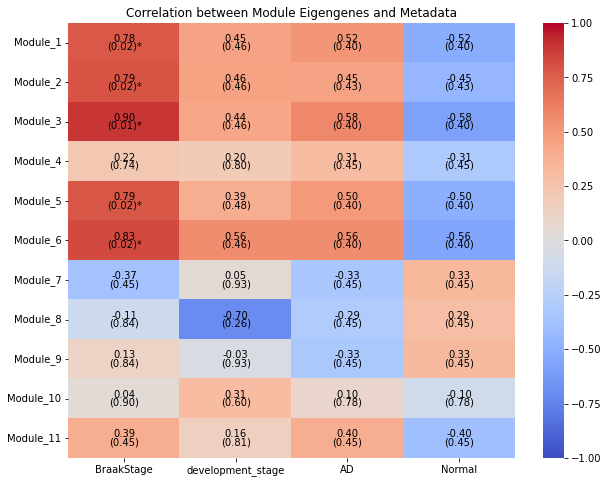

In [25]:
# Visualise the correlation matrix as a heatmap with correlation values and p-values
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix3, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Module Eigengenes and Metadata')

# Annotate heatmap with correlation values and p-values
annotate_heatmap_with_p_values(heatmap, correlation_matrix3, adjusted_p_values)

plt.show()

In [ ]:
#Exercise Questions
#1. What is a correlation and why is it used in gene co-expression analysis?
#2. Why are adjusted p-values used instead of p-values?
#3. What is fdr_bh and explain it fully?
#4. Based on the heatmap, what can you summarise?

In [ ]:
#Answers
#1.In the context of gene co-expression analysis, correlation refers to the statistical measure of the strength and direction of association between the expression levels of two genes across a set of samples or conditions. It quantifies the degree to which the expression patterns of two genes are similar or dissimilar across different biological contexts.
#2.Adjusted p-values are used instead of raw p-values in statistical hypothesis testing to correct for multiple comparisons. When conducting multiple statistical tests simultaneously (such as testing multiple genes in gene expression analysis or multiple variables in genomics studies), the probability of obtaining false positive results increases. This increased probability arises due to the cumulative effect of conducting multiple tests, leading to an inflated Type I error rate (false positives).
#3.FDR_BH stands for False Discovery Rate (FDR) control using the Benjamini-Hochberg (BH) procedure. It is a statistical method used to control the proportion of false positives among all significant results when conducting multiple hypothesis tests simultaneously.
#4.Modules 1, 2, 3, 5 and 6 appear to have the strongest, significant correlations with Braak stage, as well as relatively strong correlations with development stage and AD clinical metadata variables, highlighting them as being of interest in context of disease.
#WhereasModules 7, 8 and 9 seem to be slightly associated with Normal category.